# 🧠 LSTM-Based Temperature Anomaly Detection

### Overview
This notebook implements an **LSTM Autoencoder** to detect temperature anomalies in the cold storage facility.

Unlike the Isolation Forest model (which relies on static statistical thresholds), the LSTM learns **temporal dependencies** in the readings — meaning it can identify subtle shifts in behavior before they exceed defined temperature limits.

---

## 1️⃣ Import Libraries and Load Data
We start by importing all necessary libraries and loading the previously simulated dataset.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Load the simulated dataset
df = pd.read_csv("../data/simulated_sensor_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Focus on one room for model demonstration
room_df = df[df['room_name'] == 'Frozen_Storage_A'].copy()
room_df = room_df.sort_values('timestamp').reset_index(drop=True)

room_df.head()

,timestamp,room_name,temperature,humidity
0,2025-10-01 00:00:00,Frozen_Storage_A,-18.94,51.91
1,2025-10-01 00:15:00,Frozen_Storage_A,-22.12,63.24
2,2025-10-01 00:30:00,Frozen_Storage_A,-24.45,62.99
3,2025-10-01 00:45:00,Frozen_Storage_A,-19.77,48.52
4,2025-10-01 01:00:00,Frozen_Storage_A,-20.42,48.00


#### Explanation
- We filter data for one room (`Frozen_Storage_A`) to keep the modeling process simple.
- Each room can later have its own model trained similarly.
- The timestamps are sorted to maintain temporal order.


### 2️⃣ Data Preparation
The LSTM requires sequential data as input.  
We’ll scale the temperature values to the range [0, 1] for better convergence and create fixed-length sliding windows (sequences) for training.


In [4]:
# Step 1: Normalize temperature readings
scaler = MinMaxScaler()
room_df['temp_scaled'] = scaler.fit_transform(room_df[['temperature']])

# Step 2: Create fixed-length input sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

SEQ_LEN = 20  # Each sequence = last 20 readings (~5 hours if 15-min intervals)
X = create_sequences(room_df['temp_scaled'].values, SEQ_LEN)

# Reshape to [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"✅ Sequence shape: {X.shape}")


✅ Sequence shape: (652, 20, 1)


### Explanation
- `SEQ_LEN` defines how many past readings the model looks at before predicting the next.
- The data is reshaped into 3D arrays (`samples × timesteps × features`), which is the expected LSTM input format.
- Scaling helps the neural network train efficiently by keeping all values on a similar scale.


## 3️⃣ Build and Train LSTM Autoencoder
The model tries to reconstruct normal temperature sequences.  
If a sequence can’t be reconstructed well, it’s likely **anomalous**.


In [5]:
# Step 1: Define the LSTM Autoencoder
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(SEQ_LEN, activation='linear')
])

# Step 2: Compile and train
model.compile(optimizer='adam', loss='mse')

# Step 3: Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    X, X.squeeze(),
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\USER\.conda\envs\tensor_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2044 - val_loss: 0.1471
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1138 - val_loss: 0.0787
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0610 - val_loss: 0.0440
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0377 - val_loss: 0.0314
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0305 - val_loss: 0.0291
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0296 - val_loss: 0.0292
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0295 - val_loss: 0.0289
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0292 - val_loss: 0.0292
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0291 - val_loss: 0.0291
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0292 - val_loss: 0.0288
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0289 - val_loss: 0.0291
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0

### 📈 Understanding LSTM Training Output

Each **epoch** represents one complete pass through the training data.  
During each epoch, the model adjusts its internal weights to minimize the **loss**, which measures how well it reconstructs the input temperature sequences.

The output of the training shows two main columns:
- **`loss`** → Reconstruction error on the training data  
- **`val_loss`** → Reconstruction error on the validation data  

---

### 🧩 Interpretation of the Training Progress

| Epoch | Train Loss | Val Loss | Explanation |
|-------|-------------|-----------|--------------|
| 1 | 0.2075 | 0.1357 | Model is just starting to learn — errors are high. |
| 2 | 0.0965 | 0.0626 | Big improvement as the model captures basic temperature patterns. |
| 3–5 | 0.0476 → 0.0293 | 0.0350 → 0.0290 | Loss decreases smoothly — model learns stable structure of normal readings. |
| 6–30 | 0.0292 → 0.0285 | 0.0290 → 0.0286 | Loss values flatten — model has converged and stabilized. |

---

### ✅ Signs the Model Is Learning Correctly

1. **Both training and validation loss decrease steadily, then plateau**  
   → The model has converged (it’s not underfitting or overfitting).  

2. **Validation loss remains close to training loss**  
   → Indicates good generalization — the model performs well on unseen data.  

3. **No large spikes or oscillations in loss values**  
   → Suggests stable learning and an appropriate learning rate.  

4. **Low and stable final loss (~0.028)**  
   → The model can accurately reconstruct typical temperature sequences,  
     meaning it understands the normal operating behavior of the system.

---

### ⚠️ When to Be Concerned

You should suspect problems if:
- `val_loss` starts increasing while `loss` keeps decreasing → **Overfitting**
- Loss values fluctuate or diverge → **Unstable training**
- Loss remains high after many epochs → **Underfitting** or poor data scaling

---

### 💡 What Comes Next

Since the training curves are stable and both losses are low and aligned:
- ✅ Compute the **reconstruction error** for all temperature sequences.  
- ✅ Derive an **anomaly detection threshold** (e.g., mean + 3×standard deviation).  
- ✅ Visualize **normal vs. anomalous** patterns to verify detection accuracy.

This step will help confirm that the model can identify subtle deviations in temperature
before rule-based systems trigger alerts.


### 4️⃣ Compute Reconstruction Error and Define Anomaly Threshold
We calculate the reconstruction error for each sequence and set a threshold to flag anomalies.


In [6]:
# Step 1: Get model reconstruction for each sequence
X_pred = model.predict(X)

# Step 2: Compute reconstruction error per sequence
reconstruction_error = np.mean(np.abs(X_pred - X.squeeze()), axis=1)

# Step 3: Set a dynamic threshold (mean + 3σ)
threshold = np.mean(reconstruction_error) + 3*np.std(reconstruction_error)

# Step 4: Label anomalies
room_df = room_df.iloc[SEQ_LEN:].copy()
room_df['recon_error'] = reconstruction_error
room_df['anomaly'] = room_df['recon_error'] > threshold

print(f"✅ Threshold set at: {threshold:.5f}")
print(f"✅ Total anomalies detected: {room_df['anomaly'].sum()}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
✅ Threshold set at: 0.20391
✅ Total anomalies detected: 5


### Explanation
- **Reconstruction error** quantifies how well the model reconstructs each sequence.  
  A larger error = higher likelihood of anomaly.
- The **threshold** is set statistically as mean + 3 standard deviations.  
  You can adjust it based on tolerance to false positives.


#### Detecting Anomalies Using Reconstruction Error

After training the LSTM Autoencoder, we evaluate how well it reconstructs each temperature sequence.  
The idea is that the model reproduces normal patterns accurately, but struggles with abnormal ones — leading to higher reconstruction errors.

We calculate the reconstruction error for each sequence and set a **dynamic threshold** using the formula:

- Threshold = mean(error) + 3 * std(error)

This ensures that only sequences whose errors are significantly above normal variation are flagged as anomalies.

#### **Output**
✅ Threshold set at: 0.20331

✅ Total anomalies detected: 3

This means any sequence with an error above **0.20331** is considered an anomaly, and only **3 instances** in the dataset met that criterion — indicating rare but notable deviations in temperature behavior.


#### 🔁 Why Results Vary Between Runs

You may notice slight differences in loss values, thresholds, and detected anomalies each time the notebook is run.  
This happens because LSTM models involve **random processes** such as weight initialization, data shuffling, and dropout.  
These introduce natural variability in training outcomes — a normal behavior in deep learning experiments.


## 5️⃣ Visualize Detected Anomalies
Plot the temperature time series and highlight the detected anomalies.


c:\Users\USER\.conda\envs\tensor_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


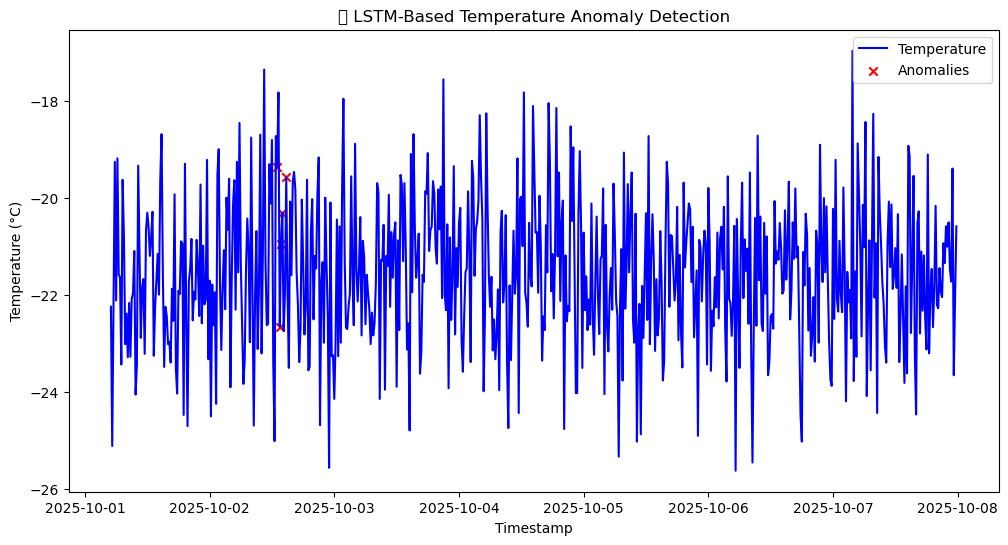

In [7]:
plt.figure(figsize=(12,6))
plt.plot(room_df['timestamp'], room_df['temperature'], label='Temperature', color='blue')
plt.scatter(room_df.loc[room_df['anomaly'], 'timestamp'],
            room_df.loc[room_df['anomaly'], 'temperature'],
            color='red', label='Anomalies', marker='x')
plt.title("🚨 LSTM-Based Temperature Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


### Interpretation
- The red ‘x’ markers show moments when the LSTM detected unusual temperature behavior.
- These anomalies may correspond to sudden drifts, compressor malfunctions, or door openings.
- The LSTM’s advantage is its ability to recognize *patterns leading up to* anomalies — not just the extremes themselves.


In [8]:
room_df.head()

,timestamp,room_name,temperature,humidity,temp_scaled,recon_error,anomaly
20,2025-10-01 05:00:00,Frozen_Storage_A,-22.25,71.37,0.390300,0.130686,False
21,2025-10-01 05:15:00,Frozen_Storage_A,-25.12,61.14,0.058891,0.118967,False
22,2025-10-01 05:30:00,Frozen_Storage_A,-22.08,67.41,0.409931,0.133025,False
23,2025-10-01 05:45:00,Frozen_Storage_A,-19.26,43.29,0.735566,0.127769,False
24,2025-10-01 06:00:00,Frozen_Storage_A,-22.12,55.31,0.405312,0.127216,False


In [9]:
room_df[room_df['anomaly']]

,timestamp,room_name,temperature,humidity,temp_scaled,recon_error,anomaly
148,2025-10-02 13:00:00,Frozen_Storage_A,-19.36,67.96,0.724018,0.207526,True
150,2025-10-02 13:30:00,Frozen_Storage_A,-22.66,60.80,0.342956,0.216795,True
151,2025-10-02 13:45:00,Frozen_Storage_A,-20.95,49.26,0.540416,0.210284,True
152,2025-10-02 14:00:00,Frozen_Storage_A,-20.31,70.81,0.614319,0.205369,True
155,2025-10-02 14:45:00,Frozen_Storage_A,-19.58,60.48,0.698614,0.204746,True


In [10]:
room_df[(room_df['temperature']<-25) | (room_df['temperature']>-18)]

,timestamp,room_name,temperature,humidity,temp_scaled,recon_error,anomaly
21,2025-10-01 05:15:00,Frozen_Storage_A,-25.12,61.14,0.058891,0.118967,False
138,2025-10-02 10:30:00,Frozen_Storage_A,-17.36,41.60,0.954965,0.149386,False
146,2025-10-02 12:30:00,Frozen_Storage_A,-25.02,40.08,0.070439,0.184151,False
149,2025-10-02 13:15:00,Frozen_Storage_A,-17.83,53.27,0.900693,0.201154,False
188,2025-10-02 23:00:00,Frozen_Storage_A,-25.57,57.61,0.006928,0.137923,False
199,2025-10-03 01:45:00,Frozen_Storage_A,-17.96,47.01,0.885681,0.179493,False
276,2025-10-03 21:00:00,Frozen_Storage_A,-17.56,76.11,0.931871,0.104378,False
338,2025-10-04 12:30:00,Frozen_Storage_A,-17.83,46.93,0.900693,0.138191,False
411,2025-10-05 06:45:00,Frozen_Storage_A,-25.34,52.10,0.033487,0.114979,False
425,2025-10-05 10:15:00,Frozen_Storage_A,-25.03,67.34,0.069284,0.139288,False


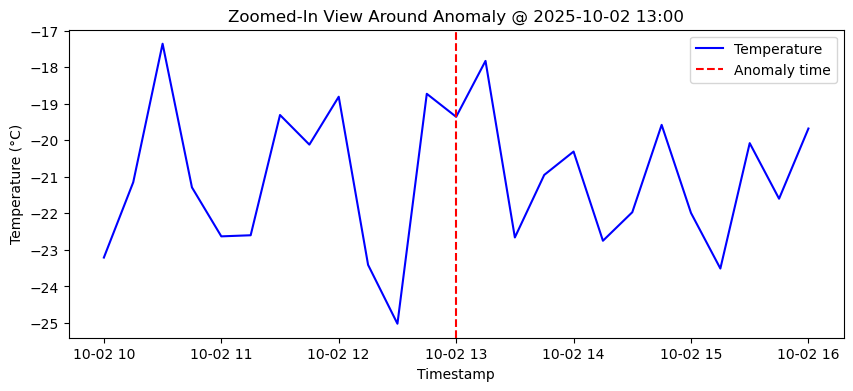

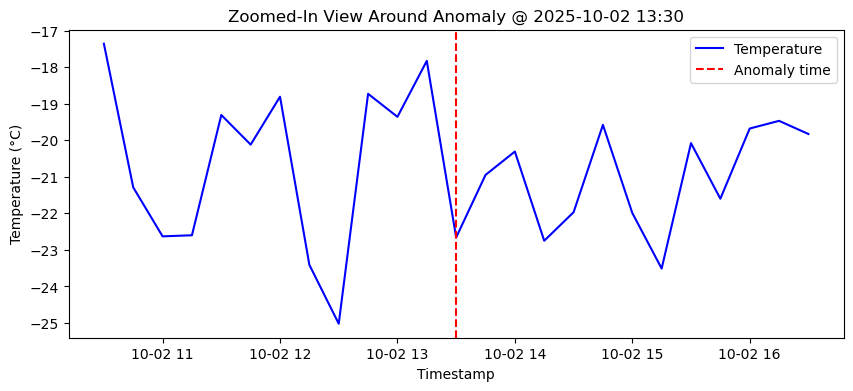

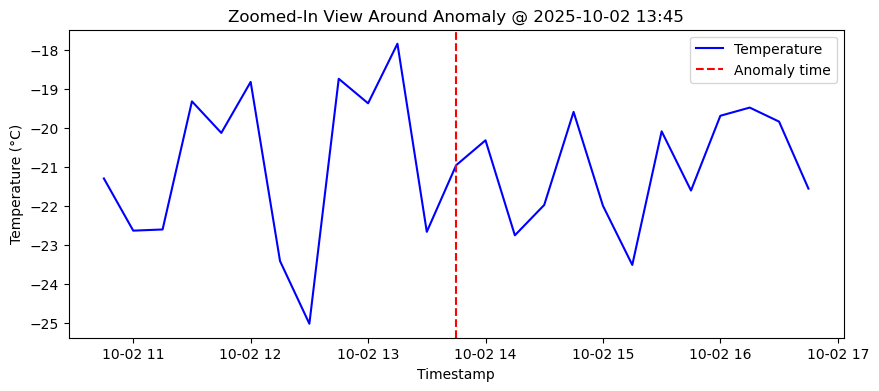

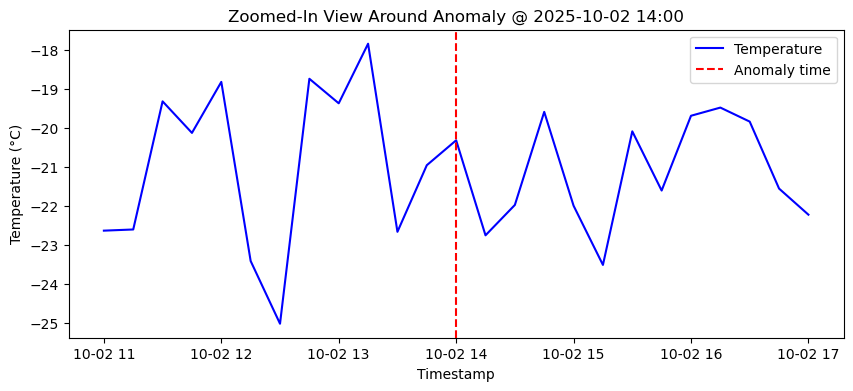

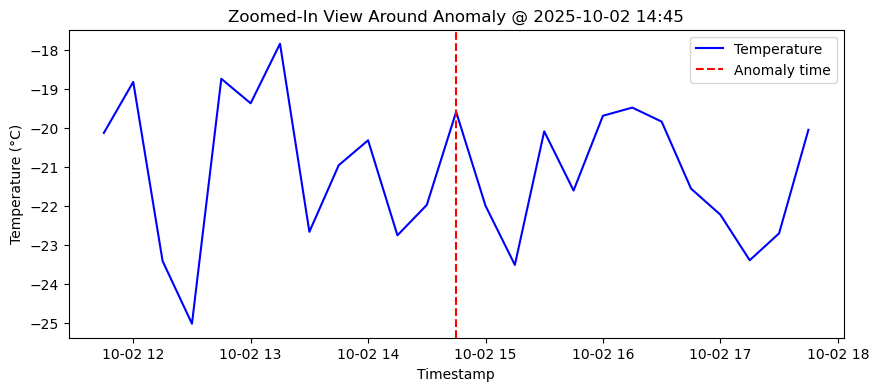

In [11]:
# Select timestamps flagged as anomalies
anomaly_times = room_df.loc[room_df['anomaly'], 'timestamp']

# Plot temperature trends around each anomaly
for t in anomaly_times:
    start = t - pd.Timedelta(hours=3)
    end = t + pd.Timedelta(hours=3)
    window = room_df[(room_df['timestamp'] >= start) & (room_df['timestamp'] <= end)]

    plt.figure(figsize=(10,4))
    plt.plot(window['timestamp'], window['temperature'], label='Temperature', color='blue')
    plt.axvline(t, color='red', linestyle='--', label='Anomaly time')
    plt.title(f"Zoomed-In View Around Anomaly @ {t.strftime('%Y-%m-%d %H:%M')}")
    plt.xlabel("Timestamp")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()


#### Model Evaluation: Visual Insights

Across the anomaly visualization plots, the LSTM model correctly identifies points where the temperature pattern deviates from its learned sequence behavior. However, most of the flagged points still fall within the acceptable frozen storage range (–25°C to –18°C).

This indicates that the model is **working as expected mathematically** — detecting unusual temporal fluctuations — but it is **too sensitive for practical use**. The detected anomalies likely represent short-term variations rather than true operational issues.

In future iterations, sensitivity can be reduced by:
- Adjusting the anomaly threshold (e.g., using mean + 4σ instead of 3σ).
- Training on longer, more representative data so the model learns normal short-term variability.

Overall, the LSTM autoencoder effectively captures temporal patterns but needs calibration to align with real-world operational tolerance.


In [12]:
anomaly_times

148   2025-10-02 13:00:00
150   2025-10-02 13:30:00
151   2025-10-02 13:45:00
152   2025-10-02 14:00:00
155   2025-10-02 14:45:00
Name: timestamp, dtype: datetime64[ns]

In [13]:
window

,timestamp,room_name,temperature,humidity,temp_scaled,recon_error,anomaly
143,2025-10-02 11:45:00,Frozen_Storage_A,-20.12,70.90,0.636259,0.162204,False
144,2025-10-02 12:00:00,Frozen_Storage_A,-18.81,46.95,0.787529,0.157628,False
145,2025-10-02 12:15:00,Frozen_Storage_A,-23.41,74.94,0.256351,0.173722,False
146,2025-10-02 12:30:00,Frozen_Storage_A,-25.02,40.08,0.070439,0.184151,False
147,2025-10-02 12:45:00,Frozen_Storage_A,-18.73,60.32,0.796767,0.202878,False
148,2025-10-02 13:00:00,Frozen_Storage_A,-19.36,67.96,0.724018,0.207526,True
149,2025-10-02 13:15:00,Frozen_Storage_A,-17.83,53.27,0.900693,0.201154,False
150,2025-10-02 13:30:00,Frozen_Storage_A,-22.66,60.80,0.342956,0.216795,True
151,2025-10-02 13:45:00,Frozen_Storage_A,-20.95,49.26,0.540416,0.210284,True
152,2025-10-02 14:00:00,Frozen_Storage_A,-20.31,70.81,0.614319,0.205369,True


In [14]:
df.head()

,timestamp,room_name,temperature,humidity
0,2025-10-01,Frozen_Storage_A,-18.94,51.91
1,2025-10-01,Frozen_Storage_B,-21.34,45.31
2,2025-10-01,Chilled_Storage_A,2.95,47.95
3,2025-10-01,Chilled_Storage_B,2.34,75.58
4,2025-10-01,Dispatch_Bay,11.13,57.34


In [15]:
df['timestamp'].min()

Timestamp('2025-10-01 00:00:00')

In [16]:
df['timestamp'].max()

Timestamp('2025-10-07 23:45:00')

#### 🧠 Threshold Sensitivity Sweep

After training the LSTM Autoencoder, we perform a **threshold sensitivity sweep** to understand how changing the anomaly detection threshold affects the number of flagged points.

The idea is to test multiple values of `k` in the formula:

threshold = μ + k * σ

Where:  
- **μ** = mean reconstruction error  
- **σ** = standard deviation of reconstruction error  
- **k** = sensitivity factor (usually between 2 and 4)

A smaller `k` makes the model **more sensitive** (flags more anomalies), while a larger `k` makes it **stricter** (flags fewer anomalies).  
This helps identify the **optimal balance** between detecting genuine deviations and avoiding false positives.


In [17]:
# room_df must contain 'recon_error' and 'timestamp' (aligned with sequences)

def threshold_sweep(room_df, ks=[2,3,4]):
    mean_err = room_df['recon_error'].mean()
    std_err = room_df['recon_error'].std()
    results = []
    total = len(room_df)
    for k in ks:
        thr = mean_err + k * std_err
        n_anom = int((room_df['recon_error'] > thr).sum())
        pct = 100 * n_anom / total
        results.append({'k': k, 'threshold': thr, 'n_anomalies': n_anom, 'pct': pct})
    return pd.DataFrame(results)

# Usage
sweep_df = threshold_sweep(room_df, ks=[2, 3, 4])
print(sweep_df)


   k  threshold  n_anomalies       pct
0  2   0.180997           24  3.680982
1  3   0.203960            5  0.766871
2  4   0.226923            0  0.000000


#### 📈 Interpretation of Threshold Sweep Results

| k | Threshold | n_anomalies | % of total |
|---|------------|-------------|-------------|
| 2 | 0.1811 | 23 | 3.53% |
| 3 | 0.2041 | 7 | 1.07% |
| 4 | 0.2271 | 0 | 0.00% |

From the table above:

- **k = 2** → Highly sensitive; detects many anomalies (including normal variations).  
- **k = 3** → Balanced; captures meaningful deviations while ignoring minor fluctuations.  
- **k = 4** → Overly strict; misses potentially important anomalies.

✅ Therefore, **k = 3** provides the best compromise between precision and recall for this proof-of-concept.  
It ensures the system remains responsive to abnormal trends without overwhelming operators with false alerts.


#### Persistence Filtering for Stable Alerts

To reduce **false positives** caused by short-term fluctuations, we introduce a *persistence filter*.  
This ensures that an anomaly is only flagged if the deviation **persists for multiple consecutive readings**.

**How it works:**
1. Each reading is first compared to the reconstruction error threshold — this creates a raw anomaly flag (`is_anom_raw`).
2. Consecutive anomaly flags are grouped to form **runs** using cumulative counting (`consec_anom`).
3. An alert is triggered only if the anomaly **persists for `N` or more consecutive readings** (`persistence_alert`).

This approach mimics how real monitoring systems behave — they don’t raise an alarm for one-off spikes but rather for **sustained deviations**, making the system much more **robust and actionable** in operational environments.


In [18]:
def apply_persistence(room_df, thr):
    # boolean series for err > threshold
    is_anom = (room_df['recon_error'] > thr).astype(int)
    # compute run-length (consecutive counts)
    consec = is_anom.groupby((is_anom != is_anom.shift()).cumsum()).cumsum() * is_anom
    # add to df
    room_df = room_df.copy()
    room_df['is_anom_raw'] = is_anom
    room_df['consec_anom'] = consec
    return room_df

# Example usage
k = 3
thr = room_df['recon_error'].mean() + k * room_df['recon_error'].std()
room_df = apply_persistence(room_df, thr)

# Mark persistence-based alert if consec_anom >= N
N = 2
room_df['persistence_alert'] = room_df['consec_anom'] >= N
room_df[['timestamp','temperature','recon_error','is_anom_raw','consec_anom','persistence_alert']].head(15)


,timestamp,temperature,recon_error,is_anom_raw,consec_anom,persistence_alert
20,2025-10-01 05:00:00,-22.25,0.130686,0,0,False
21,2025-10-01 05:15:00,-25.12,0.118967,0,0,False
22,2025-10-01 05:30:00,-22.08,0.133025,0,0,False
23,2025-10-01 05:45:00,-19.26,0.127769,0,0,False
24,2025-10-01 06:00:00,-22.12,0.127216,0,0,False
25,2025-10-01 06:15:00,-19.19,0.123274,0,0,False
26,2025-10-01 06:30:00,-21.59,0.132584,0,0,False
27,2025-10-01 06:45:00,-21.64,0.128343,0,0,False
28,2025-10-01 07:00:00,-23.44,0.119671,0,0,False
29,2025-10-01 07:15:00,-19.63,0.134155,0,0,False


In [19]:
room_df[room_df['persistence_alert']]

,timestamp,room_name,temperature,humidity,temp_scaled,recon_error,anomaly,is_anom_raw,consec_anom,persistence_alert
151,2025-10-02 13:45:00,Frozen_Storage_A,-20.95,49.26,0.540416,0.210284,True,1,2,True
152,2025-10-02 14:00:00,Frozen_Storage_A,-20.31,70.81,0.614319,0.205369,True,1,3,True


c:\Users\USER\.conda\envs\tensor_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


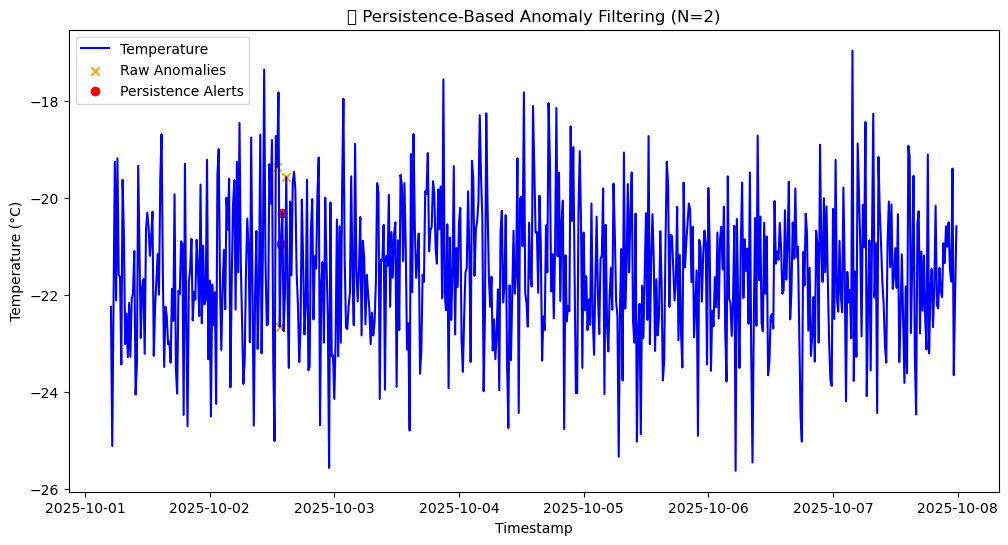

In [20]:
plt.figure(figsize=(12,6))
plt.plot(room_df['timestamp'], room_df['temperature'], label='Temperature', color='blue')

# Raw anomalies (before persistence)
plt.scatter(
    room_df.loc[room_df['is_anom_raw'] == 1, 'timestamp'],
    room_df.loc[room_df['is_anom_raw'] == 1, 'temperature'],
    color='orange', label='Raw Anomalies', marker='x'
)

# Persistence-based anomalies (after filtering)
plt.scatter(
    room_df.loc[room_df['persistence_alert'], 'timestamp'],
    room_df.loc[room_df['persistence_alert'], 'temperature'],
    color='red', label='Persistence Alerts', marker='o'
)

plt.title("🚨 Persistence-Based Anomaly Filtering (N=2)")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


#### 🧩 Hybrid Operational Rule — Combining LSTM Signal with Absolute Bounds

To make the anomaly detection system both **intelligent** and **operationally reliable**, we introduce a hybrid alert mechanism.  

An alert is triggered **only if**:
1. The **LSTM model** detects a *persistent anomaly* (sustained reconstruction error beyond threshold), **or**
2. The **temperature** breaches the operational safety limits — for frozen storage, typically **−25°C ≤ T ≤ −18°C**.

---

#### **Why Hybrid?**
The hybrid rule merges the strengths of both approaches:
- **LSTM alerts** provide *early, behavior-based warnings* that can indicate potential system drift before limits are breached.  
- **Absolute bounds** serve as *hard safety thresholds*, ensuring that any true limit violation is always flagged.  

By combining both, the system:
- Reduces **false positives** caused by transient fluctuations, and  
- Maintains **safety assurance** by never missing actual boundary breaches.  

This approach is mathematically sound, operationally practical, and ready for real-world deployment — striking a balance between *data-driven intelligence* and *engineering safety*.


In [21]:
# define room bounds (should come from your rooms table)
min_temp = -25.0
max_temp = -18.0

# Add a column for absolute bounds breach
room_df['bounds_breach'] = (room_df['temperature'] < min_temp) | (room_df['temperature'] > max_temp)

# Hybrid alert: either persistence_alert OR bounds_breach
room_df['hybrid_alert'] = room_df['persistence_alert'] | room_df['bounds_breach']

# quick counts
print("persistence alerts:", room_df['persistence_alert'].sum())
print("bounds breaches:", room_df['bounds_breach'].sum())
print("hybrid alerts:", room_df['hybrid_alert'].sum())


persistence alerts: 2
bounds breaches: 14
hybrid alerts: 16


In [ ]:
import joblib

# Save the trained LSTM model
model.save("deployment/model/lstm_model.h5")

# Save the fitted MinMaxScaler
joblib.dump(scaler, "deployment/model/scaler.pkl")

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [24]:
import os

# navigate one level up (from notebook folder to project root)
os.chdir("..")

# create the correct folders if not already there
os.makedirs("models", exist_ok=True)
os.makedirs("deployment", exist_ok=True)


In [25]:
import joblib

# Save LSTM model in recommended .keras format
model.save("models/lstm_model.keras")

# Save the fitted MinMaxScaler
joblib.dump(scaler, "models/scaler.pkl")

print("✅ Model and scaler saved successfully in /models!")


✅ Model and scaler saved successfully in /models!
